In [ ]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
# !pip install unidecode
# !pip install word2number
# !pip install contractions
# !pip install textsearch
# !pip install tqdm
# !pip install pyspellchecker

## Imports

In [ ]:
import numpy as np
import pandas as pd 
from pandas_profiling import ProfileReport
from tqdm import tqdm
tqdm.pandas()
from pprint import pprint
from string import punctuation
from collections import Counter
from spellchecker import SpellChecker
from scipy import stats
import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('ggplot') 

import warnings 
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [242]:
import numpy as np
import pandas as pd 
from pandas_profiling import ProfileReport
from tqdm import tqdm
tqdm.pandas()
from pprint import pprint

from string import punctuation
from collections import Counter
from scipy import stats
import unicodedata
import spacy

import re
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import pymorphy2

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('ggplot') 

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/stasyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stasyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tools

In [269]:
stop_words = nltk.corpus.stopwords.words('russian')+['это', 'также', 'абдо']
morph = pymorphy2.MorphAnalyzer()
snow = nltk.stem.SnowballStemmer(language="russian")

In [243]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")
    return text

def remove_URL(text):
      url = re.compile(r'http(s*)?://\S+|www\.\S+')
      return url.sub(r'',text)

def lemmatize_text(text):
      text = morph.parse(text)
      text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
      return text

def stemming(text):
  text = ' '.join([snow.stem(word) for word in text.split()])
  return text

def remove_special_characters(text, remove_digits=False):
  pattern = r'[^а-яА-Я0-9\s]' if not remove_digits else r'[^а-яА-Я\s]'
  text = re.sub(pattern, '', text)
  return text

def remove_stopwords(text, is_lower_case=False, stopwords=None):
  if not stopwords:
    stopwords = nltk.corpus.stopwords.words('russian')
  tokens = nltk.word_tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
    filtered_tokens = [token for token in tokens if token not in stopwords]
  else:
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text


In [184]:
def text_pre_processor(text, html_strip=True, URL_removal=True, 
                       text_lower_case=True, text_stemming=False, 
                       text_lemmatization=True, special_char_removal=True, 
                       remove_digits=True, stopword_removal=True, 
                       stopword_list=None):
  if html_strip:
    text = strip_html_tags(text)

  if URL_removal:
    text = remove_URL(text)
      
  if special_char_removal:
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    text = special_char_pattern.sub(" \\1 ", text)
    text = remove_special_characters(text, remove_digits=remove_digits)  
      
  if text_lemmatization:
    text = lemmatize_text(text)
    
  if text_stemming and not text_lemmatization:
    text = stemming(text)
      
  if text_lower_case:
    text = text.lower()
      
  if stopword_removal:
    text = remove_stopwords(text, is_lower_case=text_lower_case, 
                                stopwords=stopword_list)
    
  # remove extra whitespace
  text = re.sub(' +', ' ', text)
  return text

## Initial Look at the Data

Посмотрим на данные из нашего корпуса

In [270]:
with open("../Lab_1_parsing/corpora.json", 'r') as f:
    data = json.load(f)

data = pd.DataFrame(data['catalog'])
print(f'Shape is {data.shape}')
data.head()

Shape is (5005, 5)


,article_id,title,category,tags,text
0,https://www.newsru.com/finance/02Apr2020/urals...,Цены на российскую нефть Urals опустились до м...,Экономика,"Экономика, Нефть, Цены",Стоимость российской нефти марки Urals упала д...
1,https://www.newsru.com/finance/19Nov2019/perep...,Польша заявила о многомиллионных переплатах за...,Экономика,"Экономика, Газ, Польша",Польская нефтегазовая компания PGNiG начиная с...
2,https://www.newsru.com/finance/01Sep2020/balti...,Страны Балтии договорились не покупать электро...,Экономика,"СНГ, Белоруссия, АЭС",Ответственные за энергетику министерства Латви...
3,https://www.newsru.com/finance/10Jan2021/rucas...,С 10 января в России вступили в силу новые пра...,Экономика,"Экономика, Деньги, Наличные","10 января вступают в силу поправки к закону ""О..."
4,https://www.newsru.com/finance/02Nov2019/dolg....,Госдолг США достиг рекордной отметки в $23 трл...,Экономика,"Экономика, США, Внешний долг",Государственный долг США впервые превысил $23 ...


In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  5005 non-null   object
 1   title       5005 non-null   object
 2   category    5005 non-null   object
 3   tags        5005 non-null   object
 4   text        5005 non-null   object
dtypes: object(5)
memory usage: 195.6+ KB


In [163]:
data.isna().sum()

article_id    0
title         0
category      0
tags          0
text          0
dtype: int64

In [142]:
data.duplicated().sum()

0

Дубликатов, нанов нет

In [130]:
data.iloc[0, 4]

'Стоимость российской нефти марки Urals упала до 10 долларов за баррель. Это наименьший уровень с марта 1999 года, сообщает издание Argus Media. При этом российский бюджет на ближайшие три года был сформирован с учетом того, что Urals будет стоить 42,4 доллара за баррель.\r\n \r\nМежду тем фьючерсы на нефть марки Brent на бирже Ice начали расти после заявлений президента США Дональда Трампа о том, что Россия и Саудовская Аравия вскоре договорятся о мерах по регулированию рынка. Кроме того, Argus Media подчеркивает, что из-за снижения международных цен затраты на транспортировку, оплату экспортной пошлины и некоторые другие расходы превышают среднюю стоимость Urals. Иными словами, экспорт российской нефти Urals стал убыточным. Такая ситуация застала врасплох многих участников рынка, так как их цены на поставки нефти по контрактам как годовым, так и краткосрочным базируются на значении формулы в течение месяца поставки.\r\n \r\nПо итогам марта среднее значение котировки еще осталось поло

Данные грязные. Имеются html теги, пунктуация, специальные знаки. Надо чистить  


Технологии      1002
Культура        1001
Спорт           1001
Недвижимость    1001
Экономика       1000
Name: category, dtype: int64


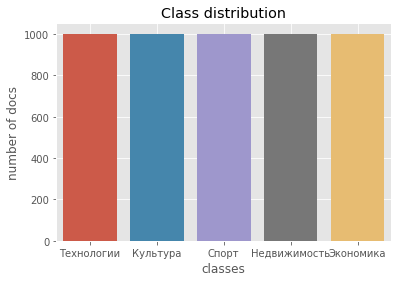

In [272]:
v_counts = data['category'].value_counts()
print(v_counts)

ax = sns.barplot(x=v_counts.index, y=v_counts.values)
ax.grid(True)
ax.set(xlabel='classes', ylabel='number of docs', title='Сlass distribution')
plt.show()

У нас есть 5 категорий, по которым мы классифицируем. Наш датасет сбалансированный

## EDA

Немного почистим данные от html тегов и исследуем их на предмет дополнительных фич

In [273]:
data['clean'] = data['text'].progress_apply(strip_html_tags)
data.head()

100%|██████████| 5005/5005 [00:00<00:00, 9355.23it/s] 


,article_id,title,category,tags,text,clean
0,https://www.newsru.com/finance/02Apr2020/urals...,Цены на российскую нефть Urals опустились до м...,Экономика,"Экономика, Нефть, Цены",Стоимость российской нефти марки Urals упала д...,Стоимость российской нефти марки Urals упала д...
1,https://www.newsru.com/finance/19Nov2019/perep...,Польша заявила о многомиллионных переплатах за...,Экономика,"Экономика, Газ, Польша",Польская нефтегазовая компания PGNiG начиная с...,Польская нефтегазовая компания PGNiG начиная с...
2,https://www.newsru.com/finance/01Sep2020/balti...,Страны Балтии договорились не покупать электро...,Экономика,"СНГ, Белоруссия, АЭС",Ответственные за энергетику министерства Латви...,Ответственные за энергетику министерства Латви...
3,https://www.newsru.com/finance/10Jan2021/rucas...,С 10 января в России вступили в силу новые пра...,Экономика,"Экономика, Деньги, Наличные","10 января вступают в силу поправки к закону ""О...","10 января вступают в силу поправки к закону ""О..."
4,https://www.newsru.com/finance/02Nov2019/dolg....,Госдолг США достиг рекордной отметки в $23 трл...,Экономика,"Экономика, США, Внешний долг",Государственный долг США впервые превысил $23 ...,Государственный долг США впервые превысил $23 ...


### Basic statistics on the text

Посчитаем некоторые статистики: длину текста, кол-во слов, различные знаки препинания, капслоковые слова  

In [280]:
def n_punct(text):
  counter = Counter(c for line in text for c in line if c in punctuation)
  return sum(counter.values())

def calculate_stats(text_df):
  stats = pd.DataFrame()
  stats['len'] = text_df.apply(lambda x: len(x))
  stats['n_words'] = text_df.apply(lambda x: len(re.findall(r'\w+', x)))
  stats['n_uppercase'] = text_df.apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
  stats['uppercase_ratio'] = stats['n_uppercase'] / (stats['n_words'] + 1e-09)

  stats['n_punct'] = text_df.apply(n_punct)
  stats['n_points'] = text_df.apply(lambda x: x.count('.'))
  stats['points_ratio'] = stats['n_points'] / (stats['n_punct'] + 1e-09)
  stats['n_exclamation'] = text_df.apply(lambda x: x.count('!'))
  stats['exclamation_ratio'] = stats['n_exclamation'] / (stats['n_punct'] + 1e-09)
  return stats

In [282]:
%%time
stats = calculate_stats(data['clean'])
stats = stats[['n_words', 'uppercase_ratio', 'points_ratio', 'exclamation_ratio']]

CPU times: user 5.33 s, sys: 12.7 ms, total: 5.34 s
Wall time: 5.35 s


Посмотрим распределение фич для каждой категории

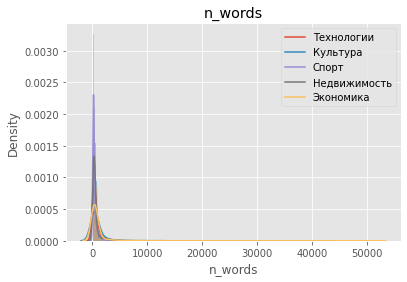

None

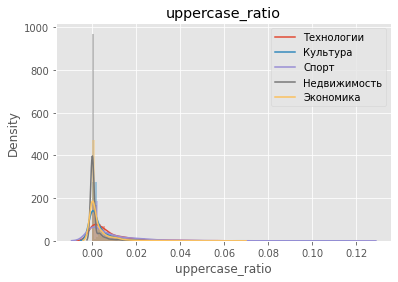

None

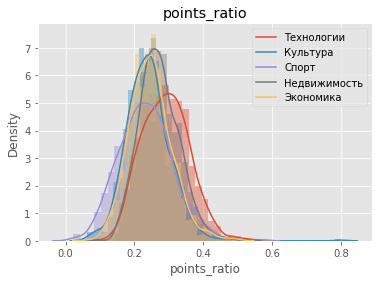

None

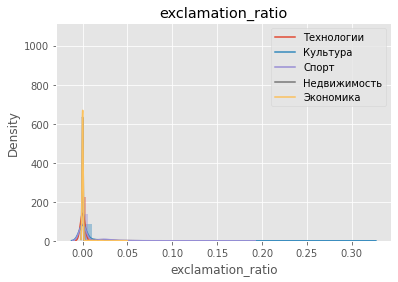

None

In [283]:
tech_ind = data[data['category']=='Технологии'].index.tolist()
cult_ind = data[data['category']=='Культура'].index.tolist()
sport_ind = data[data['category']=='Спорт'].index.tolist()
build_ind = data[data['category']=='Недвижимость'].index.tolist()
econ_ind = data[data['category']=='Экономика'].index.tolist()

for stat in stats.columns:
    sns.distplot(stats[stat][tech_ind])
    sns.distplot(stats[stat][cult_ind])
    sns.distplot(stats[stat][sport_ind])
    sns.distplot(stats[stat][build_ind])
    sns.distplot(stats[stat][econ_ind])
    plt.title(stat)
    plt.legend(['Технологии', 'Культура', 'Спорт', 'Недвижимость', 'Экономика'])
    display(plt.show())

Только распределение точек во всех категориях примерно одинаковое. Остальные признаки можно использовать для feature-engineering

#### Wordclouds

Для иллюстрации нарисуем вордклауды для каждой каждой категории

In [284]:
def cloud(data, stop_words, ngram_range=(1,1), n_words=50, class_='Технологии'):
  vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words)
  counts_pos = vectorizer.fit_transform(data[data['category']==class_]['clean'])
  sum_words = counts_pos.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  wordCloud_pos = WordCloud(max_words=n_words, background_color = 'green', 
                            height=500, width=750)
  wordCloud_pos.generate_from_frequencies(dict(words_freq))
  
  plt.imshow(wordCloud_pos)
  plt.grid(False)
  plt.title(class_)
  plt.show()

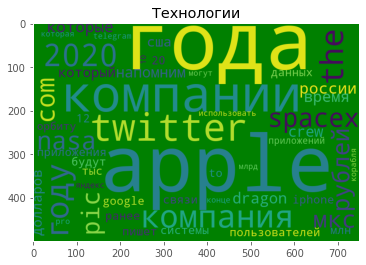

None

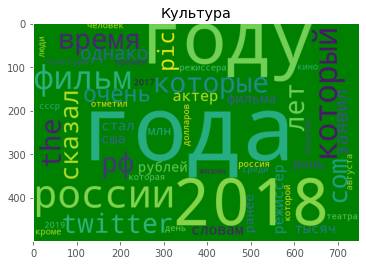

None

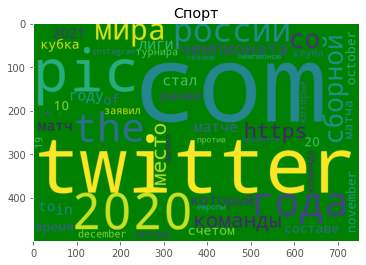

None

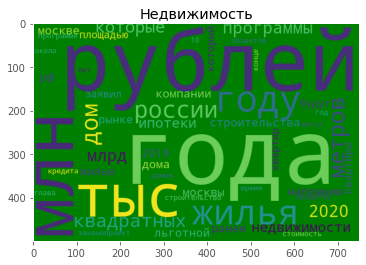

None

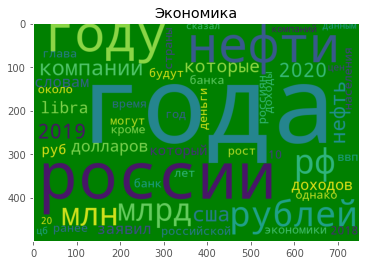

None

In [285]:
display(cloud(data, stop_words+['не', 'нет'], ngram_range=(1,1), n_words=50, class_ = 'Технологии'))
display(cloud(data, stop_words+['не', 'нет'], ngram_range=(1,1), n_words=50, class_ = 'Культура'))
display(cloud(data, stop_words+['не', 'нет'], ngram_range=(1,1), n_words=50, class_ = 'Спорт'))
display(cloud(data, stop_words+['не', 'нет'], ngram_range=(1,1), n_words=50, class_ = 'Недвижимость'))
display(cloud(data, stop_words+['не', 'нет'], ngram_range=(1,1), n_words=50, class_ = 'Экономика'))

## Preprocessing

In [286]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], 
                                                    data['category'], 
                                                    test_size=0.3,  
                                                    shuffle=True, 
                                                    stratify=data['category'])


In [287]:
train = X_train.to_frame().join(y_train)
print(train.shape)
print(train['category'].value_counts())
train['category'] =  train["category"].astype('category')
train["class"] = train["category"].cat.codes
train

(3503, 2)
Культура        701
Технологии      701
Недвижимость    701
Спорт           700
Экономика       700
Name: category, dtype: int64


,text,category,class
2322,Российское антидопинговое агентство (РУСАДА) п...,Спорт,2
1572,Представители Роскомнадзора не пришли не перво...,Технологии,3
287,"""Альфа-банк"" подтвердил утечку данных нескольк...",Экономика,4
1310,"Компания Sony провела очередное мероприятие, п...",Технологии,3
4808,Госдума 13 декабря приняла в третьем чтении по...,Недвижимость,1
...,...,...,...
4315,24 сентября в России вступят в силу принятые в...,Недвижимость,1
130,Недоверие бизнеса к российским правоохранитель...,Экономика,4
2534,Первая сборная России дисквалифицирована по ит...,Спорт,2
556,Правительство Саудовской Аравии оказывает давл...,Экономика,4


In [288]:
test = X_test.to_frame().join(y_test)
print(test.shape)
print(test['category'].value_counts())
test['category'] =  test["category"].astype('category')
test["class"] = test["category"].cat.codes
test.head()

(1502, 2)
Технологии      301
Спорт           301
Культура        300
Экономика       300
Недвижимость    300
Name: category, dtype: int64


,text,category,class
2187,Сборная России по спортивной гимнастике снялас...,Спорт,2
1374,"Компания ""МаксимаТелеком"", которая является оп...",Технологии,3
1285,Японские ученые закончили извлечение грунта ас...,Технологии,3
4476,Архитектурное бюро Zaha Hadid Architects (ZHA)...,Недвижимость,1
2485,"В Орландо баскетболисты ""Лос-Анджелес Лейкерс""...",Спорт,2


Почистим данные от html тегов, уберем ссылки, приведем к нижнему регистру, сделаем лемматизацию, уберем специальные знаки и числа и стопсловаwords.

In [289]:
%%time
train['clean'] = train['text'].progress_apply(text_pre_processor, 
                                             html_strip=True, 
                                             URL_removal=True, 
                                             text_lower_case=True, 
                                             text_stemming=False, 
                                             text_lemmatization=False, 
                                             special_char_removal=True, 
                                             remove_digits=True, 
                                             stopword_removal=True, 
                                             stopword_list=stop_words)

100%|██████████| 3503/3503 [00:16<00:00, 208.57it/s]

CPU times: user 16.5 s, sys: 240 ms, total: 16.7 s
Wall time: 16.8 s


In [290]:
%%time
test['clean'] = test['text'].progress_apply(text_pre_processor, 
                                             html_strip=True, 
                                             URL_removal=True, 
                                             text_lower_case=True, 
                                             text_stemming=False, 
                                             text_lemmatization=False, 
                                             special_char_removal=True, 
                                             remove_digits=True, 
                                             stopword_removal=True, 
                                             stopword_list=stop_words)

100%|██████████| 1502/1502 [00:08<00:00, 180.43it/s]

CPU times: user 8.16 s, sys: 122 ms, total: 8.28 s
Wall time: 8.33 s


## Bag of Words

In [291]:
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 18000,
                             min_df = 2,
                             ngram_range = (1,3))

In [292]:
%%time
train_bw = vectorizer.fit_transform(train['clean'])
test_bw = vectorizer.transform(test['clean'])

CPU times: user 12 s, sys: 415 ms, total: 12.4 s
Wall time: 12.5 s


In [293]:
print('train dim:', train_bw.shape, 'test dim:', test_bw.shape)

train dim: (3503, 18000) test dim: (1502, 18000)


In [294]:
f_names = vectorizer.get_feature_names()
train_sum = pd.DataFrame(np.sum(train_bw, axis=0), columns = f_names)
train_sum.head()

,абонента,абонентов,абр,абрамова,абрамович,абрамовой,абрамову,абсолютно,абсолютно бесправны,абсолютно бесправны однако,...,японской торговой,японской торговой площадки,яркое,ярлыка,ярлыка нажав,ярлыка нажав который,ярослав,ясно,яхту,ящики
0,28,85,27,86,42,41,31,236,33,33,...,24,24,31,24,24,24,34,25,27,31


## TF-IDF

In [295]:
tv = TfidfVectorizer(ngram_range = (1,3),
                    sublinear_tf = True,
                    max_features = 100000)

In [296]:
%%time
train_tv = tv.fit_transform(train['clean'])
test_tv = tv.transform(test['clean'])

CPU times: user 11.2 s, sys: 273 ms, total: 11.5 s
Wall time: 11.5 s


In [297]:
dist = np.sum(train_tv, axis=0)
checking = pd.DataFrame(dist,columns = vocab)
checking

,абас,абас уверя,абас уверя драк,аббревиатур,абд,абд врач,абд врач определ,абд газет,абд газет спортэкспресс,абд котор,...,яуз снесл ма,ячейк,ячейк аппарат,ячейк аппарат стал,ячейк факт,ячейк факт сбо,яшкин,яшкин шайб,яшкин шайб заброс,ящик
0,0.075825,0.378922,0.151253,0.048958,0.047736,0.047736,0.050083,0.050083,0.050083,0.93789,...,0.028733,0.352262,0.100082,0.035343,0.190308,0.039706,0.039706,0.139627,0.02571,0.02571


In [298]:
print('Training dim:',train_tv.shape, 'Test dim:', test_tv.shape)

Training dim: (3503, 100000) Test dim: (1502, 100000)


## Modeling

Добавим кросс-валидацию

In [301]:
kfold = StratifiedKFold(n_splits = 5, random_state = 2018 , shuffle=True) #cross-validator

In [302]:
models = {}

### Logistic Regression

In [303]:
def LR_model(train_data, train_labels, param):
  lr = LogisticRegression(random_state=42)
  gs_lr = GridSearchCV(lr, param_grid = [param], cv = kfold, 
                       scoring = 'roc_auc', n_jobs = -1, verbose = 0)
  gs_lr.fit(train_data, train_labels)
  print(f'Best params: {gs_lr.best_params_}')
  print(f'Best score: {gs_lr.best_score_}')
  return gs_lr


In [333]:
lr_param = {'penalty': ['l2', 'elasticnet', 'none'],
              'C': [0.001,0.1,1,1000],
              'class_weight': [{1:1}, {1:4}]}

In [313]:
%%time
models['lr_tv'] = LR_model(train_tv, train['class'], lr_param)

Best params: {'C': 0.001, 'class_weight': {1: 1}, 'penalty': 'l2'}
Best score: nan
CPU times: user 4.72 s, sys: 2.52 s, total: 7.24 s
Wall time: 1min 50s


In [314]:
%%time
models['lr_bw'] = LR_model(train_bw, train['class'], lr_param)

Best params: {'C': 0.001, 'class_weight': {1: 1}, 'penalty': 'l2'}
Best score: nan
CPU times: user 6.47 s, sys: 967 ms, total: 7.44 s
Wall time: 22.7 s


### SVM

In [315]:
def LinearSVM_model(train_data, train_labels, param):
  lsv = LinearSVC(random_state=42)
  gs_lsv = GridSearchCV(lsv, param_grid = [param], verbose = 1, cv = kfold, 
                        n_jobs = -1, scoring = 'roc_auc')
  gs_lsv.fit(train_data, train_labels)
  print(f'Best params: {gs_lsv.best_params_}')
  print(f'Best score: {gs_lsv.best_score_}')
  return gs_lsv

In [316]:
lsvm_param = {'loss': ['squared_hinge'],
              'class_weight': [{1:1}, {1:4}],
              'C': [0.001,0.01,0.1,1,10,100,1000]}

In [317]:
%%time
models['lsvm_tv'] = LinearSVM_model(train_tv, train['class'], lsvm_param)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best params: {'C': 0.001, 'class_weight': {1: 1}, 'loss': 'squared_hinge'}
Best score: nan
CPU times: user 487 ms, sys: 44.9 ms, total: 532 ms
Wall time: 15.9 s


In [318]:
%%time
models['lsvm_bw'] = LinearSVM_model(train_bw, train['class'], lsvm_param)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best params: {'C': 0.001, 'class_weight': {1: 1}, 'loss': 'squared_hinge'}
Best score: nan
CPU times: user 417 ms, sys: 30.7 ms, total: 448 ms
Wall time: 2.27 s


### Naive Bayes

#### Bernoulli Naive Bayes 

In [319]:
def BNB_model(train_data, train_labels, param):

  bnb = BernoulliNB()
  gs_bnb = GridSearchCV(bnb, param_grid = [param], verbose = 1, cv = kfold, 
                        n_jobs = -1, scoring = "roc_auc")
  gs_bnb.fit(train_data, train_labels)
  gs_bnb_best = gs_bnb.best_estimator_
  print(f'Best params: {gs_bnb.best_params_}')
  print(f'Best score: {gs_bnb.best_score_}')
  return gs_bnb

In [320]:
bnb_param = {'alpha': [0, 0.001, 0.1, 10], 
             'binarize': [None, 0.001, 0.1, 10]}

In [323]:
%%time
models['bnb_tv'] = BNB_model(train_tv, train['class'], bnb_param)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'alpha': 0, 'binarize': None}
Best score: nan
CPU times: user 265 ms, sys: 30 ms, total: 295 ms
Wall time: 791 ms


In [324]:
%%time
models['bnb_bw'] = BNB_model(train_bw, train['class'], bnb_param)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'alpha': 0, 'binarize': None}
Best score: nan
CPU times: user 191 ms, sys: 19.9 ms, total: 211 ms
Wall time: 441 ms


#### Multinomial Naive Bayes

In [325]:
def MNB_model(train_data, train_labels, param):
  mnb = MultinomialNB()
  gs_mnb = GridSearchCV(mnb, param_grid = [param], verbose = 1, cv = kfold, 
                        n_jobs = -1, scoring = "roc_auc")
  gs_mnb.fit(train_data, train_labels)  
  print(f'Best params: {gs_mnb.best_params_}')
  print(f'Best score: {gs_mnb.best_score_}')
  return gs_mnb

In [326]:
mnb_params = {'alpha': [0.001, 0.1, 0.2, 1, 10, 100], 
          'fit_prior': [True, False]}

In [327]:
%%time
models['mnb_tv'] = MNB_model(train_tv, train['class'], mnb_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'alpha': 0.001, 'fit_prior': True}
Best score: nan
CPU times: user 248 ms, sys: 34.9 ms, total: 283 ms
Wall time: 850 ms


In [328]:
%%time
models['mnb_bw'] = MNB_model(train_bw, train['class'], mnb_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'alpha': 0.001, 'fit_prior': True}
Best score: nan
CPU times: user 201 ms, sys: 24.1 ms, total: 225 ms
Wall time: 374 ms


### SGD

In [338]:
def SGD_model(train_data, train_labels, param):
  sgd = SGDClassifier()
  gs_sgd = GridSearchCV(sgd, param_grid = [param], verbose = 1, cv = kfold, 
                        n_jobs = -1, scoring = "roc_auc")
  gs_sgd.fit(train_data, train_labels)
  gs_sgd_best = gs_sgd.best_estimator_
  print(f'Best params: {gs_sgd.best_params_}')
  print(f'Best score: {gs_sgd.best_score_}')
  return gs_sgd


In [339]:
sgd_params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

In [340]:
%%time
models['sgd_tv'] = SGD_model(train_tv, train['class'], sgd_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
Best score: nan
CPU times: user 2.01 s, sys: 376 ms, total: 2.39 s
Wall time: 22.8 s


In [341]:
%%time
models['sgd_bw'] = SGD_model(train_bw, train['class'], sgd_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
Best score: nan
CPU times: user 2.12 s, sys: 272 ms, total: 2.39 s
Wall time: 5min 32s


## KNeighborsClassifier

In [349]:
from sklearn.neighbors import KNeighborsClassifier

In [350]:
def KNN_model(train_data, train_labels, param):
    neigh = KNeighborsClassifier()
    gs_sgd = GridSearchCV(neigh, param_grid = [param], verbose = 1, cv = kfold, 
                        n_jobs = -1, scoring = "roc_auc")
    gs_sgd.fit(train_data, train_labels)
    gs_sgd_best = gs_sgd.best_estimator_
    print(f'Best params: {gs_sgd.best_params_}')
    print(f'Best score: {gs_sgd.best_score_}')
    return gs_sgd

In [351]:
knn_params = {
    "n_neighbors" : [2, 3, 6],
}

In [352]:
%%time
models['knn_tv'] = KNN_model(train_tv, train['class'], knn_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'n_neighbors': 2}
Best score: nan
CPU times: user 80.1 ms, sys: 43.7 ms, total: 124 ms
Wall time: 494 ms


In [353]:
%%time
models['knn_bw'] = KNN_model(train_bw, train['class'], knn_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'n_neighbors': 2}
Best score: nan
CPU times: user 81.2 ms, sys: 13.5 ms, total: 94.8 ms
Wall time: 245 ms


## DecisionTreeClassifier

In [360]:
from sklearn.tree import DecisionTreeClassifier

In [361]:
def TREE_model(train_data, train_labels, param):
    tree = DecisionTreeClassifier(random_state=0)    
    gs_sgd = GridSearchCV(tree, param_grid = [param], verbose = 1, cv = kfold, 
                        n_jobs = -1, scoring = "roc_auc")
    gs_sgd.fit(train_data, train_labels)
    gs_sgd_best = gs_sgd.best_estimator_
    print(f'Best params: {gs_sgd.best_params_}')
    print(f'Best score: {gs_sgd.best_score_}')
    return gs_sgd

In [369]:
tree_params = {
    "max_depth" : [None, 5, 10, 15],
}

In [370]:
%%time
models['tree_tv'] = TREE_model(train_tv, train['class'], tree_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'max_depth': None}
Best score: nan
CPU times: user 2.66 s, sys: 29.2 ms, total: 2.69 s
Wall time: 8.57 s


In [371]:
%%time
models['tree_bw'] = TREE_model(train_bw, train['class'], tree_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'max_depth': None}
Best score: nan
CPU times: user 1.32 s, sys: 32.1 ms, total: 1.35 s
Wall time: 3.64 s


## Comparison of Models

In [372]:
def clf_report(model, test_features, title):
  y_pred = model.predict(test_features)
  print(f'MODEL: {title}')
  print(classification_report(test['class'], y_pred))

In [373]:
for model in models:
  if model[-2:] == 'tv':
    display(clf_report(models[model], test_tv, f'{model[:-3]} on tf-idf'))

MODEL: lr on tf-idf
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       300
           1       0.93      0.96      0.95       300
           2       1.00      0.97      0.98       301
           3       0.92      0.96      0.94       301
           4       0.97      0.88      0.92       300

    accuracy                           0.95      1502
   macro avg       0.95      0.95      0.95      1502
weighted avg       0.95      0.95      0.95      1502



None

MODEL: lsvm on tf-idf
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       300
           1       0.95      0.96      0.96       300
           2       1.00      0.98      0.99       301
           3       0.96      0.95      0.95       301
           4       0.95      0.95      0.95       300

    accuracy                           0.96      1502
   macro avg       0.96      0.96      0.96      1502
weighted avg       0.96      0.96      0.96      1502



None

MODEL: bnb on tf-idf
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       300
           1       0.97      0.95      0.96       300
           2       1.00      0.93      0.97       301
           3       0.98      0.94      0.96       301
           4       0.92      0.95      0.93       300

    accuracy                           0.95      1502
   macro avg       0.95      0.95      0.95      1502
weighted avg       0.95      0.95      0.95      1502



None

MODEL: mnb on tf-idf
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       300
           1       0.97      0.97      0.97       300
           2       1.00      0.95      0.98       301
           3       0.99      0.97      0.98       301
           4       0.94      0.95      0.95       300

    accuracy                           0.97      1502
   macro avg       0.97      0.97      0.97      1502
weighted avg       0.97      0.97      0.97      1502



None

MODEL: sgd on tf-idf
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       0.98      0.98      0.98       300
           2       1.00      0.99      0.99       301
           3       0.98      0.99      0.99       301
           4       0.96      0.97      0.97       300

    accuracy                           0.98      1502
   macro avg       0.98      0.98      0.98      1502
weighted avg       0.98      0.98      0.98      1502



None

MODEL: knn on tf-idf
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       300
           1       0.88      0.98      0.93       300
           2       0.98      0.97      0.97       301
           3       0.94      0.93      0.93       301
           4       0.95      0.84      0.89       300

    accuracy                           0.94      1502
   macro avg       0.94      0.94      0.93      1502
weighted avg       0.94      0.94      0.93      1502



None

MODEL: tree on tf-idf
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       300
           1       0.84      0.83      0.84       300
           2       0.89      0.87      0.88       301
           3       0.80      0.80      0.80       301
           4       0.72      0.76      0.74       300

    accuracy                           0.79      1502
   macro avg       0.80      0.79      0.80      1502
weighted avg       0.80      0.79      0.80      1502



None

Лучшая модель на TF-IDF по accuracy (0.98):   
- SGD с параметрами {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}

In [374]:
for model in models:
  if model[-2:] == 'bw':
    display(clf_report(models[model], test_bw, f'{model[:-3]} on bw'))

MODEL: lr on bw
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       300
           1       0.98      0.95      0.96       300
           2       0.93      0.97      0.95       301
           3       0.94      0.95      0.95       301
           4       0.94      0.91      0.93       300

    accuracy                           0.94      1502
   macro avg       0.94      0.94      0.94      1502
weighted avg       0.94      0.94      0.94      1502



None

MODEL: lsvm on bw
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       300
           1       0.97      0.97      0.97       300
           2       0.99      0.98      0.98       301
           3       0.96      0.98      0.97       301
           4       0.97      0.95      0.96       300

    accuracy                           0.97      1502
   macro avg       0.97      0.97      0.97      1502
weighted avg       0.97      0.97      0.97      1502



None

MODEL: bnb on bw
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       300
           1       0.00      0.00      0.00       300
           2       0.00      0.00      0.00       301
           3       0.00      0.00      0.00       301
           4       0.00      0.00      0.00       300

    accuracy                           0.20      1502
   macro avg       0.04      0.20      0.07      1502
weighted avg       0.04      0.20      0.07      1502



None

MODEL: mnb on bw
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       300
           1       0.97      0.96      0.96       300
           2       1.00      0.94      0.97       301
           3       0.99      0.93      0.96       301
           4       0.91      0.96      0.93       300

    accuracy                           0.95      1502
   macro avg       0.96      0.95      0.95      1502
weighted avg       0.96      0.95      0.95      1502



None

MODEL: sgd on bw
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       300
           1       0.96      0.96      0.96       300
           2       0.98      0.97      0.97       301
           3       0.97      0.96      0.96       301
           4       0.92      0.93      0.92       300

    accuracy                           0.95      1502
   macro avg       0.95      0.95      0.95      1502
weighted avg       0.95      0.95      0.95      1502



None

MODEL: knn on bw
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       300
           1       0.95      0.72      0.82       300
           2       0.42      0.95      0.59       301
           3       0.90      0.51      0.65       301
           4       0.92      0.52      0.66       300

    accuracy                           0.67      1502
   macro avg       0.78      0.67      0.68      1502
weighted avg       0.78      0.67      0.68      1502



None

MODEL: tree on bw
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       300
           1       0.86      0.85      0.85       300
           2       0.90      0.91      0.91       301
           3       0.74      0.77      0.75       301
           4       0.78      0.75      0.77       300

    accuracy                           0.81      1502
   macro avg       0.81      0.81      0.81      1502
weighted avg       0.81      0.81      0.81      1502



None

Лучшая модель на TF-IDF по accuracy (0.97):  
* LSVM с параметрами {'C': 0.001, 'class_weight': {1: 1}, 'loss': 'squared_hinge'}

In [409]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

def conf_matrix(model, test_features):
    y_pred = model.predict(test_features)
    plot_confusion_matrix(model, test_features, test['class'])


In [415]:
test[test['class']==3]

,text,category,class,clean
1374,"Компания ""МаксимаТелеком"", которая является оп...",Технологии,3,компания максимателеком которая является опера...
1285,Японские ученые закончили извлечение грунта ас...,Технологии,3,японские ученые закончили извлечение грунта ас...
1538,Президент Российского союза промышленников и п...,Технологии,3,президент российского союза промышленников пре...
1427,Группа депутатов от ЛДПР внесла в Госдуму зако...,Технологии,3,группа депутатов лдпр внесла госдуму законопро...
1933,Основатель мессенджера Telegram Павел Дуров оп...,Технологии,3,основатель мессенджера павел дуров опубликовал...
...,...,...,...,...
1621,Американская космическая компания SpaceX 18 ав...,Технологии,3,американская космическая компания августа запу...
1676,Посадочная платформа и марсоход китайской мисс...,Технологии,3,посадочная платформа марсоход китайской миссии...
1421,Компания Google пригрозила отключить свой инте...,Технологии,3,компания пригрозила отключить свой интернетпои...
1668,Росстат до 2023 года закончит разработку центр...,Технологии,3,росстат года закончит разработку центральной а...


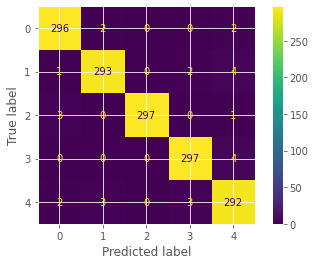

In [410]:
plot_confusion_matrix(models['sgd_tv'], test_tv, test['class'])

По конфьюжн матрице можно сказать, что только в единичных случаях предсказывается неправильно. Больше всего ошибок (4) при предсказании "Эконосики" (4 класс). Модель определяет его в класс "Технологии" (3 класс)

Оценив 7 классификаторов, мы определили лучший для мешка слов и для tf-idf. Модели дают достаточно высокие скоры.